# Dataset Balancing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

from data_prep import prepare_data, construct_pipeline, save_processed_data

## Data Exploration

In [3]:
SCENARIO_ONE_INSIDE_CSV = "../../data/DARPA_2000/Scenario_One/inside/inside_labeled_flows_all.csv"

In [4]:
df = pd.read_csv(SCENARIO_ONE_INSIDE_CSV)
df.head()

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,orig_bytes,resp_bytes,orig_pkts,resp_pkts,conn_state,local_orig,local_resp,attack_id,attack,phase
0,f0,9.524389e+08,9.524389e+08,0.101800,172.16.112.50,33354,172.16.114.50,80,tcp,http,290,7897,8,9,SF,T,T,0,0,0
1,f1,9.524389e+08,9.524389e+08,0.001107,172.16.114.50,45135,172.16.115.20,53,udp,dns,44,131,1,1,SF,T,T,0,0,0
2,f2,9.524389e+08,9.524389e+08,0.064488,172.16.113.204,22641,172.16.112.100,25,tcp,smtp,623,247,12,22,SF,T,T,0,0,0
3,f3,9.524389e+08,9.524389e+08,0.001167,172.16.112.100,1061,172.16.115.20,53,udp,dns,90,131,2,1,SF,T,T,0,0,0
4,f4,9.524389e+08,9.524389e+08,0.000861,172.16.113.204,1438,172.16.115.20,53,udp,dns,45,131,1,1,SF,T,T,0,0,0


In [5]:
def check_class_distribution(y, phases=[1,2,3,4,5], plot=False):
    
    y_filtered = [label for label in y if label in phases] 
    counts = Counter(y_filtered)
    num_samples_per_phase = dict(counts)
    
    total_num_samples = sum(counts.values())
    print(f"Total number of samples: {total_num_samples}")

    for phase in phases:
        count = counts.get(phase, 0)
        percentage = (count / total_num_samples) * 100
        print(f"Phase {phase}: {count} samples ({percentage:.2f}%)")
    
    if plot:
        plt.bar(num_samples_per_phase.keys(), num_samples_per_phase.values())
        plt.xlabel('Phase')
        plt.ylabel('Number of Flows')
        plt.title('Number of Flows per Phase in Scenario One Inside Dataset')
        plt.show()

    return num_samples_per_phase


In [6]:
y = df["phase"]

Total number of samples: 125825
Phase 0: 91972 samples (73.10%)
Phase 1: 20 samples (0.02%)
Phase 2: 22 samples (0.02%)
Phase 3: 35 samples (0.03%)
Phase 4: 22 samples (0.02%)
Phase 5: 33754 samples (26.83%)


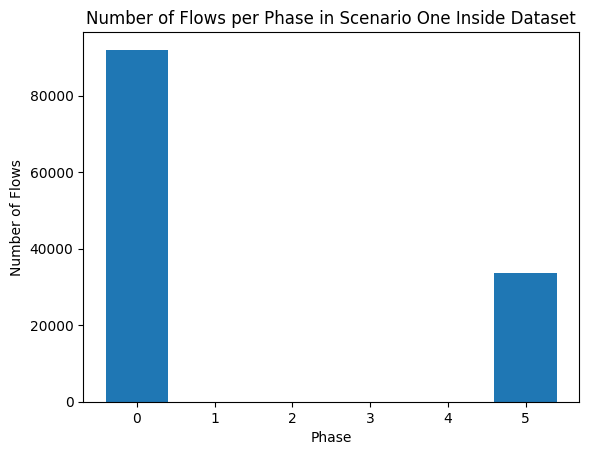

In [7]:
num_samples_per_phase_all = check_class_distribution(y, phases=[0,1,2,3,4,5], plot=True)

Total number of samples: 33853
Phase 1: 20 samples (0.06%)
Phase 2: 22 samples (0.06%)
Phase 3: 35 samples (0.10%)
Phase 4: 22 samples (0.06%)
Phase 5: 33754 samples (99.71%)


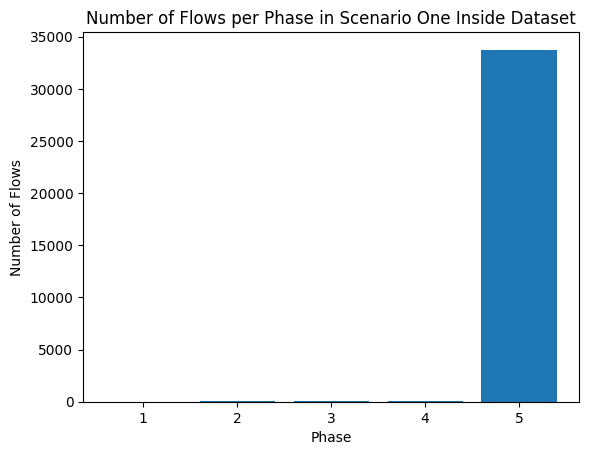

In [8]:
num_samples_per_phase_attack = check_class_distribution(y, phases=[1,2,3,4,5], plot=True)

Total number of samples: 99
Phase 1: 20 samples (20.20%)
Phase 2: 22 samples (22.22%)
Phase 3: 35 samples (35.35%)
Phase 4: 22 samples (22.22%)


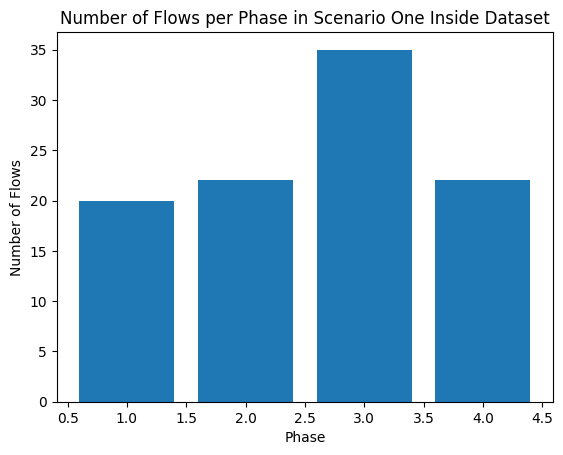

In [9]:
num_samples_per_phase_subsample = check_class_distribution(y, phases=[1,2,3,4], plot=True)

## Load the datasets

In [10]:
SEED = 123 # TODO: Investigate how to set global random seed

According to [1], we need to perform data splitting before upsampling or downsampling to avoid data leakage. 

[1] https://www.geeksforgeeks.org/machine-learning/introduction-to-upsampling-and-downsampling-imbalanced-data-in-python/

In [11]:
# Split Data into Train/Test
train_size = 0.6
test_size = 1 - train_size
df_train, df_test = train_test_split(
    df, test_size=test_size, stratify=df["attack"], random_state=SEED 
)
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

Train set shape: (75495, 20)
Test set shape: (50330, 20)


In [12]:
X_train = df_train#.drop(columns=["flow_id", "attack_id", "phase", "attack"])
X_test = df_test#.drop(columns=["flow_id", "attack_id", "phase", "attack"])

X_train.head()

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,orig_bytes,resp_bytes,orig_pkts,resp_pkts,conn_state,local_orig,local_resp,attack_id,attack,phase
30301,f30301,9.524437e+08,9.524437e+08,0.000797,172.16.113.84,1967,172.16.115.20,53,udp,dns,35,95,1,1,SF,T,T,0,0,0
121252,f121252,9.524491e+08,9.524491e+08,0.113402,172.16.116.44,21397,135.145.64.75,80,tcp,http,186,29495,13,24,SF,T,F,0,0,0
49144,f49144,9.524465e+08,9.524465e+08,0.000000,44.30.77.181,9199,131.84.1.31,27617,tcp,-,0,0,1,0,OTH,F,F,4229,1,5
34848,f34848,9.524449e+08,9.524449e+08,0.073430,172.16.117.103,1555,205.181.112.67,80,tcp,http,254,12028,9,12,SF,T,F,0,0,0
103110,f103110,9.524465e+08,9.524465e+08,0.000000,13.19.169.25,36514,131.84.1.31,21313,tcp,-,0,0,1,0,OTH,F,F,31163,1,5


In [13]:
print("\nClass distribution in Train set:")
y_train = df_train["phase"]
train_num_samples_per_phase = check_class_distribution(y_train, phases=[1,2,3,4,5])

print("\nClass distribution in Test set:")
y_test = df_test["phase"]
test_num_samples_per_phase = check_class_distribution(y_test, phases=[1,2,3,4,5])


Class distribution in Train set:
Total number of samples: 20312
Phase 1: 9 samples (0.04%)
Phase 2: 12 samples (0.06%)
Phase 3: 17 samples (0.08%)
Phase 4: 13 samples (0.06%)
Phase 5: 20261 samples (99.75%)

Class distribution in Test set:
Total number of samples: 13541
Phase 1: 11 samples (0.08%)
Phase 2: 10 samples (0.07%)
Phase 3: 18 samples (0.13%)
Phase 4: 9 samples (0.07%)
Phase 5: 13493 samples (99.65%)


## Upsampling

Upsampling can be done using a variety of techniques, such as 
- Random Oversampling,
- SMOTE,
- etc.

### Upsampling using random oversampling

In [14]:
from imblearn.over_sampling import RandomOverSampler

In [15]:
print('Before upsampling:', train_num_samples_per_phase)

Before upsampling: {5: 20261, 3: 17, 4: 13, 1: 9, 2: 12}


In [16]:
counts = Counter(df_train['phase'])
print('Before upsampling:', Counter(counts))

desired_target = max(train_num_samples_per_phase.values()) # TODO: might lead to bugs later
print('Desired target:', desired_target)

sampling_strategy = {p: max(counts[p], desired_target) for p in counts if p != 0 and p != 5}
print('Sampling strategy (per-phase target):', sampling_strategy)

ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=SEED)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
print('After upsampling:', Counter(y_train_resampled))

Before upsampling: Counter({0: 55183, 5: 20261, 3: 17, 4: 13, 2: 12, 1: 9})
Desired target: 20261
Sampling strategy (per-phase target): {3: 20261, 4: 20261, 1: 20261, 2: 20261}
After upsampling: Counter({0: 55183, 5: 20261, 3: 20261, 4: 20261, 1: 20261, 2: 20261})


In [17]:
# Convert multi-class resampled labels to binary: non-zero -> 1
y_train = (y_train_resampled != 0).astype(int)
print(f"Length of y_train: {len(y_train)}")
print(Counter(y_train))

Length of y_train: 156488
Counter({1: 101305, 0: 55183})


In [18]:
X_train_resampled.head()

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,orig_bytes,resp_bytes,orig_pkts,resp_pkts,conn_state,local_orig,local_resp,attack_id,attack,phase
0,f30301,9.524437e+08,9.524437e+08,0.000797,172.16.113.84,1967,172.16.115.20,53,udp,dns,35,95,1,1,SF,T,T,0,0,0
1,f121252,9.524491e+08,9.524491e+08,0.113402,172.16.116.44,21397,135.145.64.75,80,tcp,http,186,29495,13,24,SF,T,F,0,0,0
2,f49144,9.524465e+08,9.524465e+08,0.000000,44.30.77.181,9199,131.84.1.31,27617,tcp,-,0,0,1,0,OTH,F,F,4229,1,5
3,f34848,9.524449e+08,9.524449e+08,0.073430,172.16.117.103,1555,205.181.112.67,80,tcp,http,254,12028,9,12,SF,T,F,0,0,0
4,f103110,9.524465e+08,9.524465e+08,0.000000,13.19.169.25,36514,131.84.1.31,21313,tcp,-,0,0,1,0,OTH,F,F,31163,1,5


### Prepare upsampled data for modeling

In [19]:
# Config
ip_encoding = "none"
feature_set = ["duration", "proto", "orig_bytes", "resp_bytes", "orig_pkts", "resp_pkts"]

In [20]:
# Prepare features
df_train_features, numeric_cols, categorical_cols, ip_feature_cols = prepare_data(
    X_train_resampled, feature_set, ip_encoding=ip_encoding,     
)
df_test_features, _, _, _ = prepare_data(
    df_test, feature_set, ip_encoding=ip_encoding,
)

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)
print("IP feature cols:", ip_feature_cols)

df_train_features.head()

Numeric cols: ['duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts']
Categorical cols: ['proto']
IP feature cols: []


,duration,proto,orig_bytes,resp_bytes,orig_pkts,resp_pkts
0,0.000797,udp,35,95,1,1
1,0.113402,tcp,186,29495,13,24
2,0.000000,tcp,0,0,1,0
3,0.073430,tcp,254,12028,9,12
4,0.000000,tcp,0,0,1,0


In [31]:
# Process data with pipeline
pipeline = construct_pipeline(numeric_cols, categorical_cols)

X_train = pipeline.fit_transform(df_train_features)
y_train = X_train_resampled["attack"]
X_test = pipeline.transform(df_test_features)
y_test = df_test["attack"]

print("--- Training Data ---")
print("Feature matrix shape:", X_train.shape)
print("Labels shape:", y_train.shape)
print("--- Test Data ---")
print("Feature matrix shape:", X_test.shape)
print("Labels shape:", y_test.shape)

--- Training Data ---
Feature matrix shape: (156488, 8)
Labels shape: (156488,)
--- Test Data ---
Feature matrix shape: (50330, 8)
Labels shape: (50330,)


In [32]:
# TODO: Save processed data for modeling
output_dir = "processed_data/inside_split/scenario_one/upsampled"
save_processed_data(output_dir, X_train, y_train, X_test, y_test, pipeline, numeric_cols, categorical_cols, ip_encoding)

Saved X, y, and preprocessing pipeline to processed_data/inside_split/scenario_one/upsampled/


## Downsampling